## Load Libraries

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [78]:
method = 'conv'

In [79]:
amino_acid_full_names = {
    'A': 'alanine', 'R': 'arginine', 'N': 'asparagine', 'D': 'aspartic_acid', 'C': 'cysteine', 
    'E': 'glutamic_acid', 'Q': 'glutamine', 'G': 'glycine', 'H': 'histidine', 'I': 'isoleucine', 
    'L': 'leucine', 'K': 'lysine', 'M': 'methionine', 'F': 'phenylalanine', 'P': 'proline',
    'S': 'serine', 'T': 'threonine', 'W': 'tryptophan', 'Y': 'tyrosine', 'V': 'valine'
}

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load in amino acid image depiction

In [81]:
#store images in cache to save performance
image_cache = {}

def load_AA_image(img_path):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image

    # Maybe not do it, if vgg is not the method
    transform = transforms.ToTensor()
    
    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image


torch.Size([20, 3, 400, 400])

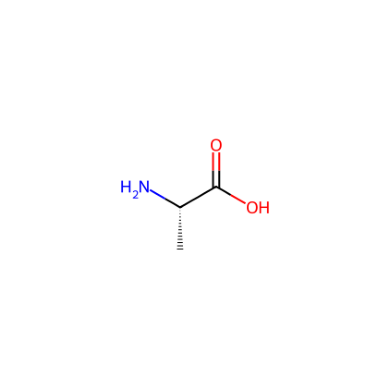

In [82]:
pixel_features = [] 

for letter, amino_acid in amino_acid_full_names.items():
    img_path = f'./data/2Dstruc/{amino_acid}.png'
    img = load_AA_image(img_path)
    pixel_features.append(img)

pixel_features = torch.vstack(pixel_features)

# Define dataloader
dataloader = DataLoader(pixel_features, batch_size=20)

# The transpose is necessary because the image is stored in a different way
plt.imshow(pixel_features[0].cpu().numpy().transpose(1, 2, 0));
plt.axis('off');
pixel_features.shape

## Linear Auto Encoder

In [83]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(400*400*3, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 20)
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400*400*3),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# Note to self: If normalization is used, we will use 
# tanh as the activation function in the last layer

## Convolutional Auto Encoder

In [84]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (N, 3, 400, 400) -> (N, 16, 200, 200)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (N, 16, 200, 200) -> (N, 32, 100, 100)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # (N, 32, 100, 100) -> (N, 64, 94, 94)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # (N, 64, 94, 94) -> (N, 32, 100, 100)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (N, 32, 100, 100) -> (N, 16, 200, 200)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # (N, 16, 200, 200) -> (N, 3, 400, 400)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Define Model, Error function and Optimizer

In [85]:
if method == 'linear':
    model = AutoEncoder().to(device)
elif method == 'conv':
    model = ConvAutoEncoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

## Train model

In [86]:
patience = 10
best_loss = float('inf')
epochs_no_improve = 0

num_epochs = 100
outputs = []

training_err = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for img in dataloader:
        
        if method == 'linear':
            img = img.reshape(-1, 400*400*3).to(device)  # Reshape with batch size preserved
        elif method == 'conv':
            img = img.to(device)

        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(dataloader)
    training_err.append(train_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    outputs.append((epoch, img, output))

    if train_loss < best_loss:
        best_loss = train_loss
        epochs_no_improve = 0
        
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print(f'Early stopping after {patience} epochs of no improvement')
        break

    torch.save(model.state_dict(), f'best_model_weights.pth')

Epoch [1/100], Loss: 0.2743
Epoch [2/100], Loss: 0.2696
Epoch [3/100], Loss: 0.2602
Epoch [4/100], Loss: 0.2464
Epoch [5/100], Loss: 0.2354
Epoch [6/100], Loss: 0.2258
Epoch [7/100], Loss: 0.2150
Epoch [8/100], Loss: 0.2023
Epoch [9/100], Loss: 0.1884
Epoch [10/100], Loss: 0.1747
Epoch [11/100], Loss: 0.1598
Epoch [12/100], Loss: 0.1414
Epoch [13/100], Loss: 0.1244
Epoch [14/100], Loss: 0.1093
Epoch [15/100], Loss: 0.0965
Epoch [16/100], Loss: 0.0845
Epoch [17/100], Loss: 0.0707
Epoch [18/100], Loss: 0.0632
Epoch [19/100], Loss: 0.0550
Epoch [20/100], Loss: 0.0437
Epoch [21/100], Loss: 0.0327
Epoch [22/100], Loss: 0.0311
Epoch [23/100], Loss: 0.0299
Epoch [24/100], Loss: 0.0290
Epoch [25/100], Loss: 0.0285
Epoch [26/100], Loss: 0.0280
Epoch [27/100], Loss: 0.0275
Epoch [28/100], Loss: 0.0271
Epoch [29/100], Loss: 0.0267
Epoch [30/100], Loss: 0.0264
Epoch [31/100], Loss: 0.0261
Epoch [32/100], Loss: 0.0256
Epoch [33/100], Loss: 0.0244
Epoch [34/100], Loss: 0.0078
Epoch [35/100], Loss: 0

## Visualize Training Error

C:\Users\Chuan\AppData\Local\Temp\ipykernel_16220\3359928179.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0.5, 1.0, 'Training Loss')

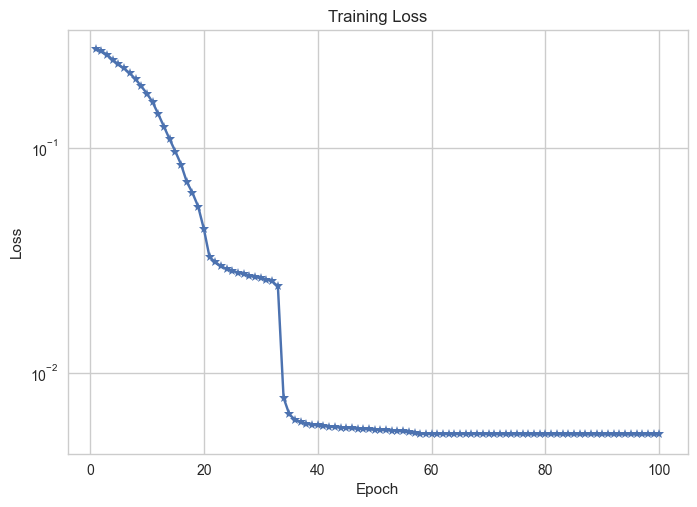

In [94]:
plt.style.use('seaborn-whitegrid')
plt.plot(range(1, num_epochs+1), training_err, '-*')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')


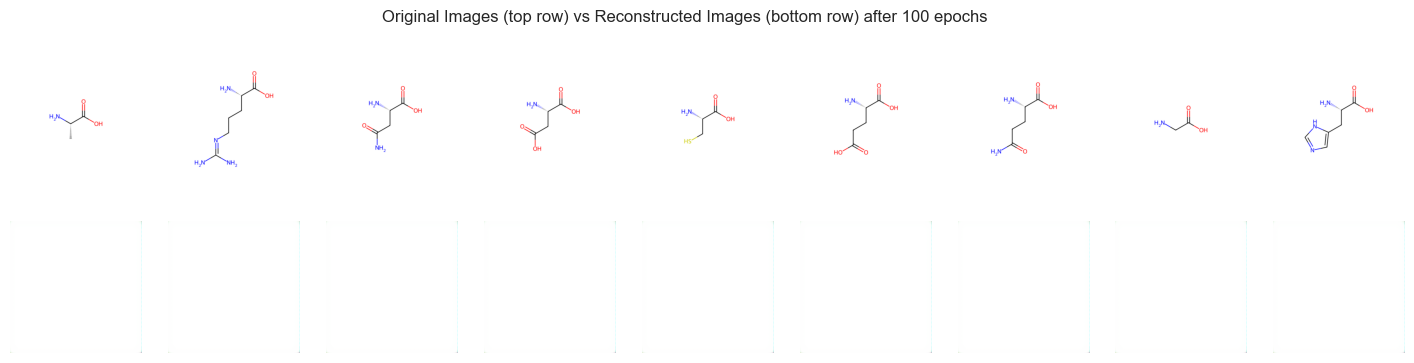

In [95]:
def plot_reconstructed_images(outputs, epoch):
    plt.figure(figsize=(18, 4))
    plt.suptitle(f'Original Images (top row) vs Reconstructed Images (bottom row) after {epoch} epochs')

    if epoch > len(outputs):
        print('The epoch number is greater than the number of epochs trained')
        return
    
    imgs = outputs[epoch-1][1].detach().cpu().numpy()
    recon = outputs[epoch-1][2].detach().cpu().numpy()

    for i, item in enumerate(imgs):
        if i >= 9:
            break
        
        plt.subplot(2, 9, i+1)

        if method == 'linear':
            item = item.reshape(-1, 3, 400, 400)
            plt.imshow(item[0].transpose(1, 2, 0))
        
        elif method == 'conv':
            plt.imshow(item.transpose(1, 2, 0))
        
        plt.axis('off')

    for i, item in enumerate(recon):
        if i >= 9:
            break

        plt.subplot(2, 9, 9+i+1)
        
        
        if method == 'linear':
            item = item.reshape(-1, 3, 400, 400)
            plt.imshow(item[0].transpose(1, 2, 0))
        
        elif method == 'conv':
            plt.imshow(item.transpose(1, 2, 0))
        
        plt.axis('off')


plot_reconstructed_images(outputs, epoch=100)